# Lane detection

In [40]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt

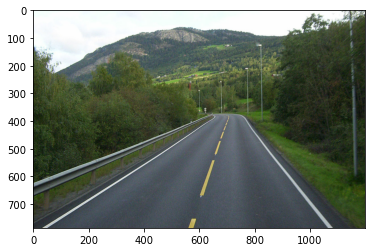

In [41]:
img=plt.imread("road1.jpg")
plt.imshow(img)

In [42]:
def stackImages(scale,imgArray):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                if imgArray[x][y].shape[:2] == imgArray[0][0].shape [:2]:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                else:
                    imgArray[x][y] = cv2.resize(imgArray[x][y], (imgArray[0][0].shape[1], imgArray[0][0].shape[0]), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
        ver = np.vstack(hor)
    else:
        for x in range(0, rows):
            if imgArray[x].shape[:2] == imgArray[0].shape[:2]:
                imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            else:
                imgArray[x] = cv2.resize(imgArray[x], (imgArray[0].shape[1], imgArray[0].shape[0]), None,scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        ver = hor
    return ver

In [43]:
def CannyImg(img,low_threshold, high_threshold,kernel_size):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blur=cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
    canny=cv2.Canny(blur, low_threshold, high_threshold)
    return canny

In [44]:
def Region(img,vertices):
    mask = np.zeros_like(img)  
    cv2.fillPoly(mask, vertices, 255)
    msk_image = cv2.bitwise_and(img, mask)
    return msk_image

In [45]:
def houghtransform(img,rho,theta,threshold,minlinelen,maxlinegap):
    lines=cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=minlinelen,maxLineGap=maxlinegap)
    return lines

In [46]:
def displaylines(img,lines):
    lineimg=np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2=line.reshape(4)
            cv2.line(img,(x1,y1),(x2,y2),(255,0,0),10)
    return lineimg

In [47]:
def combine(initial_img, img):
    combined=cv2.addWeighted(initial_img, 0.8, img, 1, 1)
    return combined

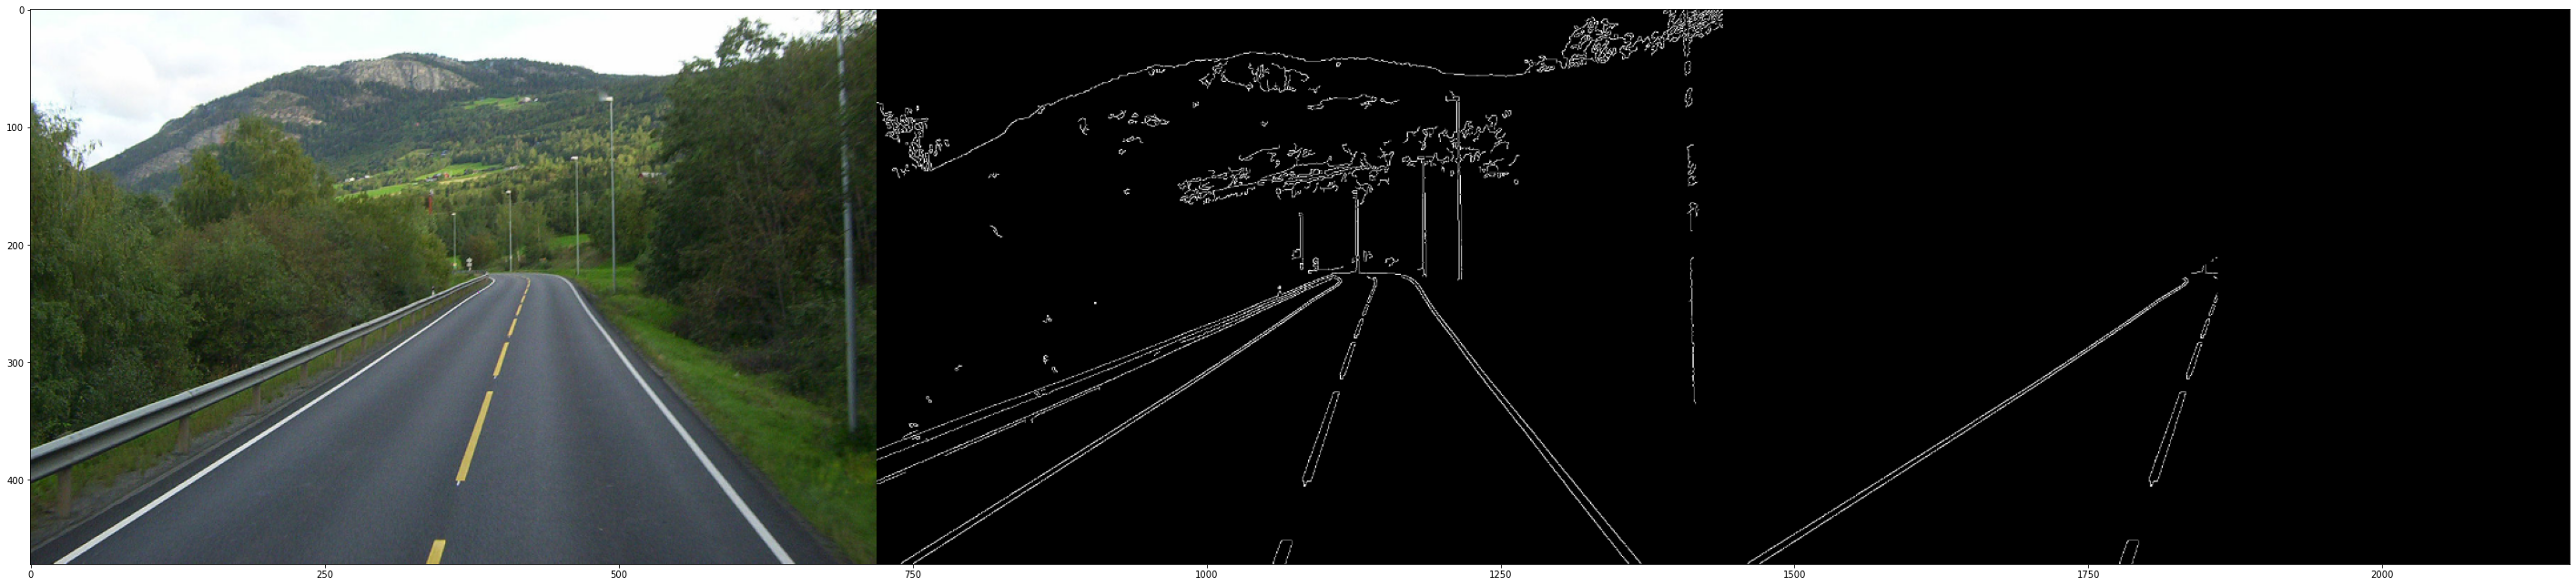

In [48]:
canny=CannyImg(img,50,150,5)

vertices=np.array([[(20,img.shape[0]),(700,img.shape[0]),(700,350)]])
# vertices=np.array([[(0,0),(img.shape[1],0),(img.shape[1],img.shape[0]),(0,img.shape[0])]])
region=Region(canny,vertices)

stack=stackImages(0.6,[img,canny,region])
plt.figure(figsize = (50,50))
plt.imshow(stack)

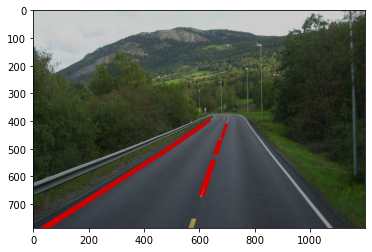

In [49]:
rho,theta,threshold,minlinelen,maxlinegap=2,np.pi/180,100,40,5
lines=houghtransform(region,rho,theta,threshold,minlinelen,maxlinegap)
# avglines=average_slope_intercept(img,lines)
lineimg=displaylines(img,lines)

combined=combine(img,lineimg)

plt.imshow(combined)

In [50]:
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            parameters = np.polyfit((x1, x2), (y1, y2), 1)
            slope = parameters[0]
            intercept = parameters[1]
            if slope < 0:
                left_fit.append((slope, intercept))
            else:
                right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])

def make_coordinates(img,line_parameters):
    slope,intercept=line_parameters
    y1=img.shape[0]
    y2=int(y1*3/5)
    x1=int((y1-intercept)/slope)
    x2=int((y2-intercept)/slope)
    return np.array([x1,y1,x2,y2])

In [51]:
vertices=np.array([[(250,img.shape[0]), (1000,img.shape[0]), (600,250)]])
rho,theta,threshold,minlinelen,maxlinegap=2,np.pi/180,100,40,5

vid=cv2.VideoCapture("lane.mp4")
while(1):
    success,img=vid.read()
    
    cannyvid=CannyImg(img,50,150,5)
    regionofvid=Region(cannyvid,vertices)
    
    lines=houghtransform(regionofvid,rho,theta,threshold,minlinelen,maxlinegap)
    avglines=average_slope_intercept(img,lines)
    lineimg=displaylines(img,avglines)

    combined=combine(img,lineimg)
    
    cv2.imshow("video",img)
    if cv2.waitKey(10) & 0xFF== ord('q'):
        cv2.destroyAllWindows()
        break